In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from pprint import pprint
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
engine.execute('SELECT max(date) FROM measurement').fetchall()

[('2017-08-23',)]

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
last_date = dt.datetime.strptime(last_date, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
last_year = last_date - dt.timedelta(days = 365)


#Perform a query to retrieve the data and precipitation scores

precip_results = (
    session.query(measurement.date,measurement.prcp)
    .filter(measurement.date > last_year)
    .order_by(measurement.date)
    .all()
)
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_results,columns = ["Date", "Precipitaion"])

# Sort the dataframe by date
precip_df["Date"] = pd.to_datetime(precip_df["Date"])
precip_df = precip_df.sort_values("Date").dropna().set_index("Date")

precip_df.describe()


,Precipitaion
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


Text(0.5, 0, '')

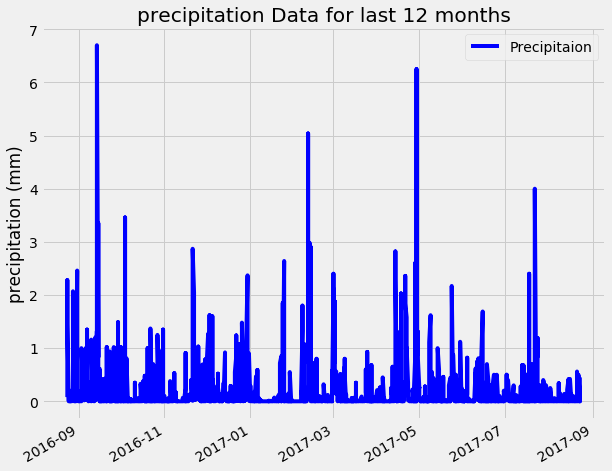

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(color="blue", figsize=(9, 8))
plt.title("precipitation Data for last 12 months")
plt.ylabel("precipitation (mm)")
plt.xlabel("")
#plt.savefig(precipitation.png)

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station.id).distinct().count()
stations

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

station_count = (session.query(measurement.station, func.count(measurement.station))
                .group_by(measurement.station)
                .order_by(func.count(measurement.station).desc())
                .all())
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = 'USC00519281'
temp = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_station).all()
temp

[(54.0, 85.0, 71.66378066378067)]

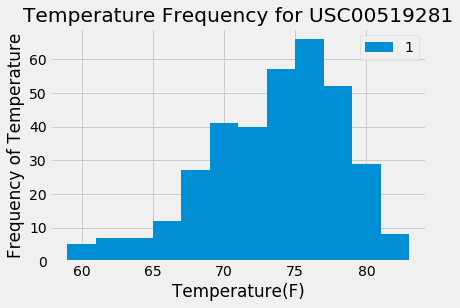

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_observation = station_count[0][0]
results = session.query(measurement.date, measurement.tobs).\
                        filter(measurement.date >= "2016-08-24").\
                        filter(measurement.date <= "2017-08-23").\
                        filter(measurement.station == temp_observation).all()
results_df = pd.DataFrame(results)

results_df.plot.hist(bins=12)
plt.ylabel("Frequency of Temperature")
plt.xlabel("Temperature(F)")
plt.title("Temperature Frequency for USC00519281")

plt.savefig("histogram.png")

# Close session

In [16]:
# Close Session
session.close()